## 5.1 ReAct Agents (Prebuilt Agents)

In [1]:
# !pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance
!pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client langgraph langchain_experimental openai --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 2.9.0 requires requests-toolbelt<1,>=0.8.0, but you have requests-toolbelt 1.0.0 which is incompatible.


## 1. Setup

In [2]:
# Imports
import os
import json
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
#from langchain_community.llms import VLLMOpenAI
from langchain_openai import ChatOpenAI
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.prompts import PromptTemplate
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

## 3. Model Configuration

#### Define the Inference Model Server specifics

In [3]:
# INFERENCE_SERVER_URL = os.getenv('API_URL')
# MODEL_NAME = "mistral-7b-instruct"
# API_KEY= os.getenv('API_KEY')


INFERENCE_SERVER_URL = "http://localhost:8000"
MODEL_NAME = "ibm-granite/granite-3.0-8b-instruct"
API_KEY= "alanliuxiang"


# INFERENCE_SERVER_URL = "https://api.feidaapi.com"
# MODEL_NAME = "gpt-4o"
# API_KEY= "sk-TsoMJYTiW1Ya1AatboGdUGXEdCOAWeCeIbvUCkNMonrCHoQ7"

#### Create the LLM instance

In [4]:
llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

## Define tools

Sometimes, for complex calculations, rather than have an LLM generate the answer directly, it can be better to have the LLM generate code to calculate the answer, and then run that code to get the answer. In order to easily do that, we provide a simple Python REPL to execute commands in.

In [6]:
repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your calculations."],
):
    """Use this to execute python code. 
    Execute the code if it's necessary, but give the final result calculated. 
    Don't show the code
    If it's needed, search first online
    Your result if calculate is not give the code, is to provide the final result
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

from langchain_community.tools import DuckDuckGoSearchRun

# Initialize DuckDuckGo Search Tool
duckduckgo_search = DuckDuckGoSearchRun()

In [7]:
from langgraph.prebuilt import ToolNode

tools = [duckduckgo_search, 
         python_repl]

In [8]:
llm_with_tools = llm.bind_tools(tools)


## Create graph

In [9]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### Define Edge Logic

In [10]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [11]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

### Define Tool Node

In [12]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [13]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [14]:
graph = graph_builder.compile(checkpointer=memory)


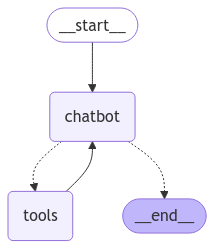

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
config = {"configurable": {"thread_id": "1"}}

In [17]:

user_input = """Search which are the top FSI in the S&P 500 in 2024."""
             
# Start streaming the conversation
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Track printed messages to avoid duplicates
printed_messages = set()

# Process each event and print only unique messages
for event in events:
    latest_message = event["messages"][-1]
    
    # Only print if message content is new
    if latest_message.content not in printed_messages:
        printed_messages.add(latest_message.content)
        latest_message.pretty_print()

================================ Human Message =================================

Search which are the top FSI in the S&P 500 in 2024.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_hY0ucaRssOxe56av1HDqlT4R)
 Call ID: call_hY0ucaRssOxe56av1HDqlT4R
  Args:
    query: top FSI in the S&P 500 in 2024
================================= Tool Message =================================
Name: duckduckgo_search

The two most interesting stocks among top-performing S&P 500 shares. Vistra also benefited from the boom in AI applications, as data center companies signed deals to procure nuclear energy. They ... Last year, it was the top performer on the S&P 500, returning 239% for the year. In fact, since 2020, it has had triple-digit returns every year except 2022, when it fell 50% during the bear market. As the top-performing S&P 500 sector, communication services surged in 2024, driven by heavyweights Meta and Google, which saw

In [18]:
user_input = "Which market cap have the top FSI, search for the results in 2024"
             
# Start streaming the conversation
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Track printed messages to avoid duplicates
printed_messages = set()

# Process each event and print only unique messages
for event in events:
    latest_message = event["messages"][-1]
    
    # Only print if message content is new
    if latest_message.content not in printed_messages:
        printed_messages.add(latest_message.content)
        latest_message.pretty_print()

================================ Human Message =================================

Which market cap have the top FSI, search for the results in 2024
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_fVAb541k4gAohCbgZBtpMqyx)
 Call ID: call_fVAb541k4gAohCbgZBtpMqyx
  Args:
    query: Palantir market cap 2024
  duckduckgo_search (call_VTq37vKRkp9KQJcPkikSZR7F)
 Call ID: call_VTq37vKRkp9KQJcPkikSZR7F
  Args:
    query: Meta market cap 2024
  duckduckgo_search (call_0z2z9a781Lfxr6aZUEBQIOMz)
 Call ID: call_0z2z9a781Lfxr6aZUEBQIOMz
  Args:
    query: Google market cap 2024
================================= Tool Message =================================
Name: duckduckgo_search

Market Cap Chart Since August 19, 2004, Alphabet's market cap has increased from $27.24B to $2.42T, an increase of 8,799.47%. That is a compound annual growth rate of 24.56%. Alphabet has a market cap or net worth of $2.42 trillion. The enterprise val

In [19]:
user_input = "Calculate the average market cap of these FSI?"
             
# Start streaming the conversation
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Track printed messages to avoid duplicates
printed_messages = set()

# Process each event and print only unique messages
for event in events:
    latest_message = event["messages"][-1]
    
    # Only print if message content is new
    if latest_message.content not in printed_messages:
        printed_messages.add(latest_message.content)
        latest_message.pretty_print()

================================ Human Message =================================

Calculate the average market cap of these FSI?
================================== Ai Message ==================================
Tool Calls:
  python_repl (call_JcmTxApfcv2G7lFgbdbUZIH9)
 Call ID: call_JcmTxApfcv2G7lFgbdbUZIH9
  Args:
    code: palantir_market_cap = 174
meta_market_cap = 1400
google_market_cap = 2420

average_market_cap = (palantir_market_cap + meta_market_cap + google_market_cap) / 3
average_market_cap


Python REPL can execute arbitrary code. Use with caution.


================================= Tool Message =================================
Name: python_repl

Successfully executed:
\`\`\`python
palantir_market_cap = 174
meta_market_cap = 1400
google_market_cap = 2420

average_market_cap = (palantir_market_cap + meta_market_cap + google_market_cap) / 3
average_market_cap
\`\`\`
Stdout: 

If you have completed all tasks, respond with FINAL ANSWER.
The average market cap of Palantir, Meta, and Google in 2024 is approximately $1,331.33 billion.================================== Ai Message ==================================

The average market cap of Palantir, Meta, and Google in 2024 is approximately $1,331.33 billion.
